## Setup

Load library:

In [17]:
import torch
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot

from sklearn.metrics import mean_squared_error, r2_score

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

* select files from directories

In [2]:
## Train
train_dir = '/home/habeebbabatunde/sentinel_aso/data/subsetsv1/train'
train_list = glob(f'{train_dir}/ASO_50M_SD*.nc')

## Val
val_dir = '/home/habeebbabatunde/sentinel_aso/data/subsetsv1/val'
val_list = glob(val_dir+'/*')

## Test
test_dir = '/home/habeebbabatunde/sentinel_aso/data/subsetsv1/test'
test_list = glob(test_dir+'/*')

* Create standardization parameters  

In [3]:
# these are set by finding the min and max across the entire dataset
norm_dict = {
    'aso_sd':[0, 24.9],
    'vv':[0, 13523.8],
    'vh':[0, 43.2],
    'AOT':[0, 572.1],
    'coastal':[0, 23459.1],
    'blue':[0, 23004.1],
    'green':[0, 26440.1],
    'red':[0, 21576.1],
    'red_edge1':[0, 20796.1],
    'red_edge2':[0, 20432.1],
    'red_edge3':[0, 20149.1],
    'nir':[0, 21217.1],
    'water_vapor':[0, 18199.1],
    'swir1':[0, 17549.1],
    'swir2':[0, 17314.1],
    'scene_class_map':[0, 15],
    'water_vapor_product':[0, 6517.5],
    'elevation':[-100, 9000]
}

* Create standardization function

In [4]:
def calc_norm(tensor, minmax_list):
    '''
    normalize a tensor between 0 and 1 using a min and max value stored in a list
    '''
    normalized = (tensor-minmax_list[0])/(minmax_list[1]-minmax_list[0])
    return normalized

* Define dataset 

In [6]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    '''
    class that reads data from a netCDF and returns normalized tensors 
    '''
    def __init__(self, path_list, norm_dict, norm=True):
        self.path_list = path_list
        self.norm_dict = norm_dict
        self.norm = norm
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.path_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        ds = xr.open_dataset(self.path_list[idx])
        #ds = ds.coarsen(x = 6, boundary = 'trim').mean().coarsen(y = 6, boundary = 'trim').mean()
        # convert to tensors
        aso_sd = torch.from_numpy(ds.aso_sd.values)
        snowon_vv = torch.from_numpy(ds.snowon_vv.values)
        snowon_vh = torch.from_numpy(ds.snowon_vh.values)
        snowoff_vv = torch.from_numpy(ds.snowoff_vv.values)
        snowoff_vh = torch.from_numpy(ds.snowoff_vh.values)
        # snowon_vv_mean = torch.from_numpy(ds.snowon_vv_mean.values)
        # snowon_vh_mean = torch.from_numpy(ds.snowon_vh_mean.values)
        # snowoff_vv_mean = torch.from_numpy(ds.snowoff_vv_mean.values)
        # snowoff_vh_mean = torch.from_numpy(ds.snowoff_vh_mean.values)
        # aerosol_optical_thickness = torch.from_numpy(ds.AOT.values)
        # coastal_aerosol = torch.from_numpy(ds.B01.values)
        blue = torch.from_numpy(ds.B02.values)
        green = torch.from_numpy(ds.B03.values)
        red = torch.from_numpy(ds.B04.values)
        # red_edge1 = torch.from_numpy(ds.B05.values)
        # red_edge2 = torch.from_numpy(ds.B06.values)
        # red_edge3 = torch.from_numpy(ds.B07.values)
        # nir = torch.from_numpy(ds.B08.values)
        # water_vapor = torch.from_numpy(ds.B09.values)
        # swir1 = torch.from_numpy(ds.B11.values)
        # swir2 = torch.from_numpy(ds.B12.values)
        # scene_class_map = torch.from_numpy(ds.SCL.values)
        # water_vapor_product = torch.from_numpy(ds.WVP.values)
        fcf = torch.from_numpy(ds.fcf.values)
        elevation = torch.from_numpy(ds.elevation.values)
        # aso_gap_map = torch.from_numpy(ds.aso_gap_map.values)
        # rtc_gap_map = torch.from_numpy(ds.rtc_gap_map.values)
        # rtc_mean_gap_map = torch.from_numpy(ds.rtc_mean_gap_map.values)
            
        # normalize layers (except gap maps and fcf)
        if self.norm == True:
            aso_sd = calc_norm(aso_sd, self.norm_dict['aso_sd'])
            snowon_vv = calc_norm(snowon_vv, self.norm_dict['vv'])
            snowon_vh = calc_norm(snowon_vh, self.norm_dict['vh'])
            snowoff_vv = calc_norm(snowoff_vv, self.norm_dict['vv'])
            snowoff_vh = calc_norm(snowoff_vh, self.norm_dict['vh'])
            # snowon_vv_mean = calc_norm(snowon_vv_mean, self.norm_dict['vv'])
            # snowon_vh_mean = calc_norm(snowon_vh_mean, self.norm_dict['vh'])
            # snowoff_vv_mean = calc_norm(snowoff_vv_mean, self.norm_dict['vv'])
            # snowoff_vh_mean = calc_norm(snowoff_vh_mean, self.norm_dict['vh'])
            # aerosol_optical_thickness = calc_norm(aerosol_optical_thickness, self.norm_dict['AOT'])
            # coastal_aerosol = calc_norm(coastal_aerosol, self.norm_dict['coastal'])
            blue = calc_norm(blue, self.norm_dict['blue'])
            green = calc_norm(green, self.norm_dict['green'])
            red = calc_norm(red, self.norm_dict['red'])
            # red_edge1 = calc_norm(red_edge1, self.norm_dict['red_edge1'])
            # red_edge2 = calc_norm(red_edge2, self.norm_dict['red_edge2'])
            # red_edge3 = calc_norm(red_edge3, self.norm_dict['red_edge3'])
            # nir = calc_norm(nir, self.norm_dict['nir'])
            # water_vapor = calc_norm(water_vapor, self.norm_dict['water_vapor'])
            # swir1 = calc_norm(swir1, self.norm_dict['swir1'])
            # swir2 = calc_norm(swir2, self.norm_dict['swir2'])
            # scene_class_map = calc_norm(scene_class_map, self.norm_dict['scene_class_map'])
            #water_vapor_product = calc_norm(water_vapor_product, self.norm_dict['water_vapor_product'])
            elevation = calc_norm(elevation, self.norm_dict['elevation'])

        # Stack selected bands into a single tensor
        input_tensor = torch.stack([snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation], dim=0).float()
    
        # Add channel dimension to aso_sd
        aso_sd = aso_sd.unsqueeze(0).float() # this adds a channel dimension, making its shape [1, 128, 128]

         
        # return only selected bands, for now
        #return aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation

        return input_tensor, aso_sd

* Create data loaders

In [7]:
# create dataloaders
train_data = dataset(train_list, norm_dict, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)


## load validation
val_data = dataset(val_list, norm_dict, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=16, shuffle=False)

## load test
test_data = dataset(test_list, norm_dict, norm=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=16, shuffle=False)

## Create baseline model

In [8]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(9, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        return x


## Plot model

This is a way to visualize the components of the model.

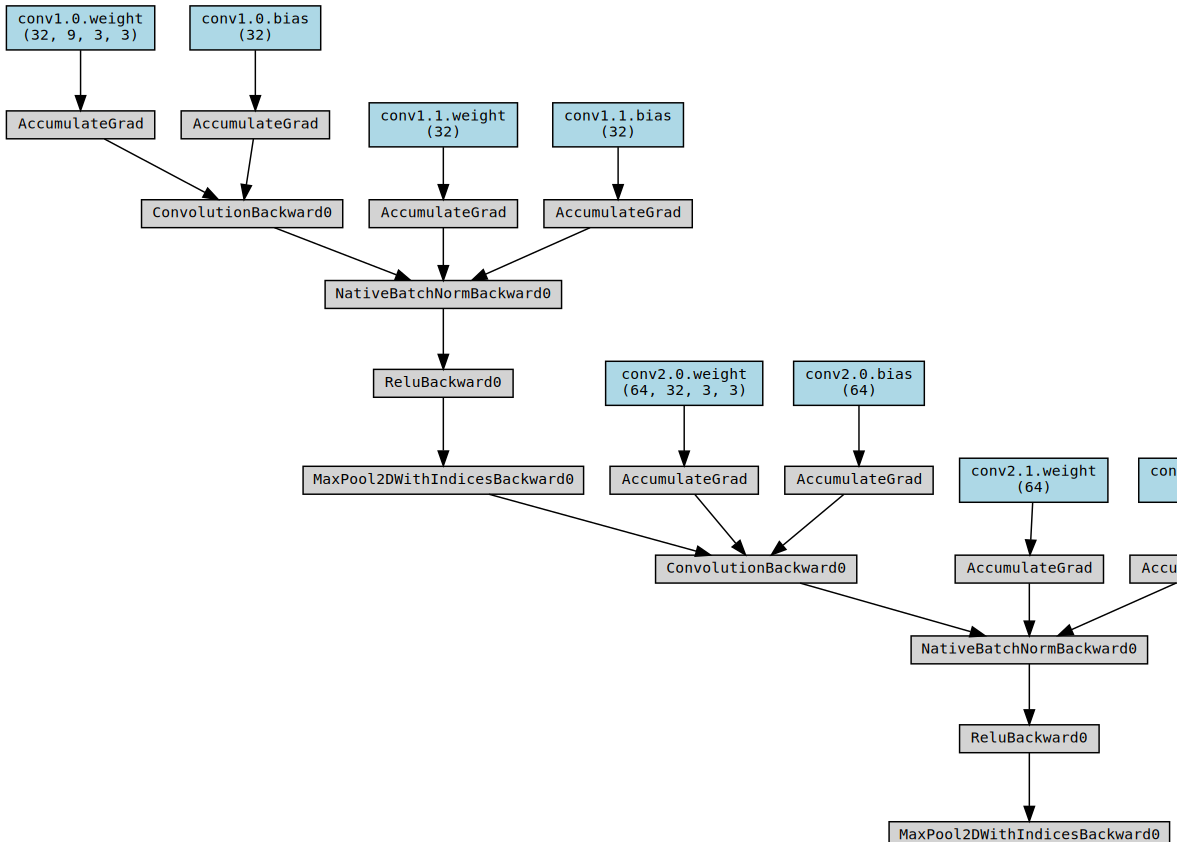

In [10]:
model = BaselineCNN()
dummy_input = torch.randn(1, 9, 128, 128)  
output = model(dummy_input)

#make_dot(output,  params=dict(list(model.named_parameters()))).render("ffn", format="png") ## this save the png model
make_dot(output,  params=dict(list(model.named_parameters())))

## A function for training

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, device=device):
    # Send model to device (e.g., 'cuda' or 'cpu')
    model.to(device)
    
    # Define the loss function and the optimizer
    criterion = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store loss values for plotting or analysis
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for i, data in enumerate(train_loader, start=0):
            # Get inputs and targets, and send them to the device
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, target)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, target = [item.to(device) for item in data]
                outputs = model(inputs)
                loss = criterion(outputs, target)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    print('Finished Training')
    return train_losses, val_losses

## A function for prediction

In [12]:
def predict(model, data_loader, device=device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []

    with torch.no_grad():
        for data in data_loader:
            inputs, _ = [item.to(device) for item in data]  # unpack inputs and ignore the target
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0) # Make it a single numpy array
    return all_predictions


## Train model

In [13]:
model = BaselineCNN()
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10)

Epoch [1/10], Train Loss: 0.0017, Val Loss: 0.0018
Epoch [2/10], Train Loss: 0.0014, Val Loss: 0.0015
Epoch [3/10], Train Loss: 0.0014, Val Loss: 0.0015
Epoch [4/10], Train Loss: 0.0013, Val Loss: 0.0015
Epoch [5/10], Train Loss: 0.0013, Val Loss: 0.0015
Epoch [6/10], Train Loss: 0.0013, Val Loss: 0.0014
Epoch [7/10], Train Loss: 0.0013, Val Loss: 0.0014
Epoch [8/10], Train Loss: 0.0012, Val Loss: 0.0015
Epoch [9/10], Train Loss: 0.0012, Val Loss: 0.0017
Epoch [10/10], Train Loss: 0.0012, Val Loss: 0.0013
Finished Training


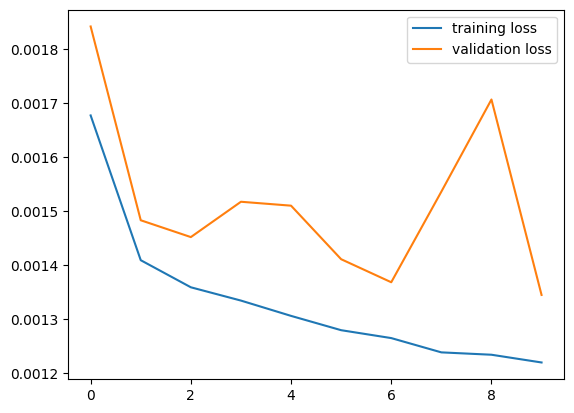

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

## Model Evaluation

In [47]:
def evaluate(true_values, predictions):
    """
    Evaluate the model's predictions using RMSE and R2.
    Args:
    - true_values (numpy array or list): Ground truth values.
    - predictions (numpy array or list): Model's predictions.

    Returns:
    - rmse (float): Root mean square error.
    - r2 (float): R2 score.
    """

    # Flatten the arrays if they have more than 1 dimension (e.g., images)
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)

    return rmse, r2

In [48]:
true_values = []    
for item in test_loader:
    true_values.extend(item[1].numpy())

true_values=np.concatenate(true_values, axis=0)
predictions = predict(model, test_loader, device=device)

rmse, r2 = evaluate(true_values, predictions)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 0.02987033873796463
R2 Score: 0.43672407894613585


## Plot Comparisons

In [152]:
def plot_multiple_true_vs_predicted(true_images, predicted_images, indices=None, num_pairs=3):
    """
    Plot multiple pairs of observed (true) vs predicted images.
    
    Parameters:
        true_images (list or array): List of true images.
        predicted_images (list or array): List of predicted images.
        num_pairs (int): Number of pairs to plot.
    """
    
    if indices is None: # If no indices are provided, randomly select some
        indices = np.random.choice(len(true_images), num_pairs, replace=False)
        fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 8))

    # Create a new figure
    fig, axes = plt.subplots(len(indices), 2, figsize=(6, 5), sharex=True, sharey=True)

    for i, idx in enumerate(indices):
        # Plot true images
        axes[i, 0].imshow(true_images[idx], cmap='viridis')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"ASO Depth", size=10)
        
        # Plot predicted images
        axes[i, 1].imshow(predicted_images[idx], cmap='viridis')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Baseline CNN Depth", size=10)

    plt.tight_layout()
    plt.show()

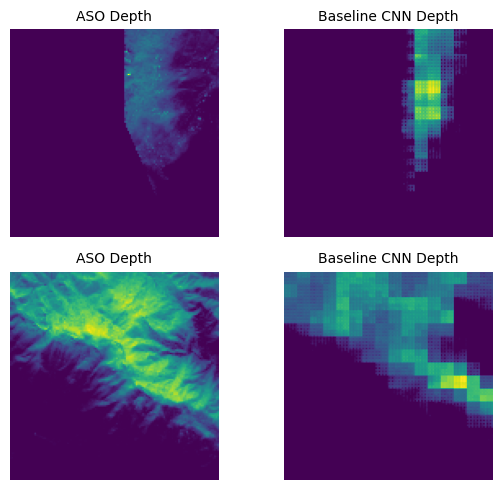

In [153]:
plot_multiple_true_vs_predicted(true_values, predictions, indices=[0,1])

## Save Model for later use

In [14]:
torch.save(model, 'baselineCNN.pth') # save using this code
model = torch.load('baselineCNN.pth') # load using this code